In [1]:
pip install pandas numpy torch scikit-learn==1.6.1 nltk beautifulsoup4 tqdm contractions wordcloud seaborn datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion", split="train")
dataset = dataset.to_pandas()

dataset.tail()


c:\Users\bahti\emotion-sentiment-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


In [5]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

dataset["emotion_name"] = dataset["label"].map(label_map)
dataset.head()

,text,label,emotion_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


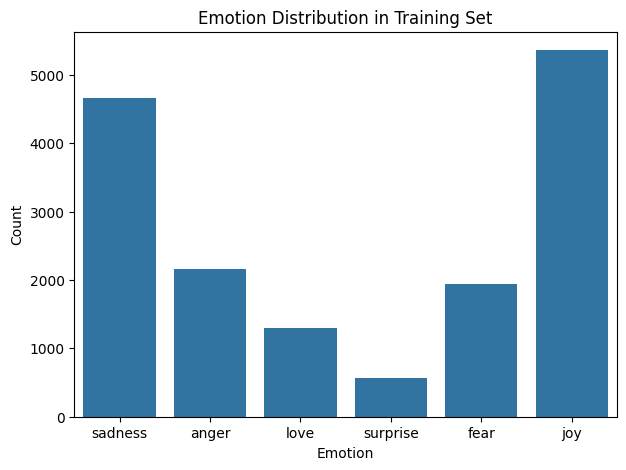

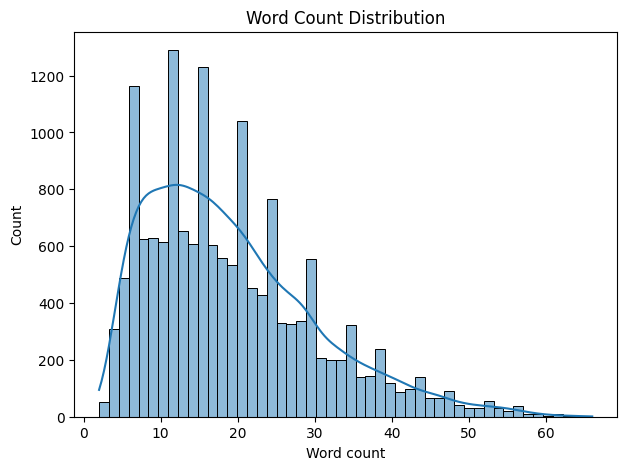

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot emotion distribution
plt.figure(figsize=(7,5))
sns.countplot(x=dataset["emotion_name"])
plt.title("Emotion Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# Word count distribution
dataset["word_count"] = dataset["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.histplot(dataset["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word count")
plt.ylabel("Count")
plt.show()

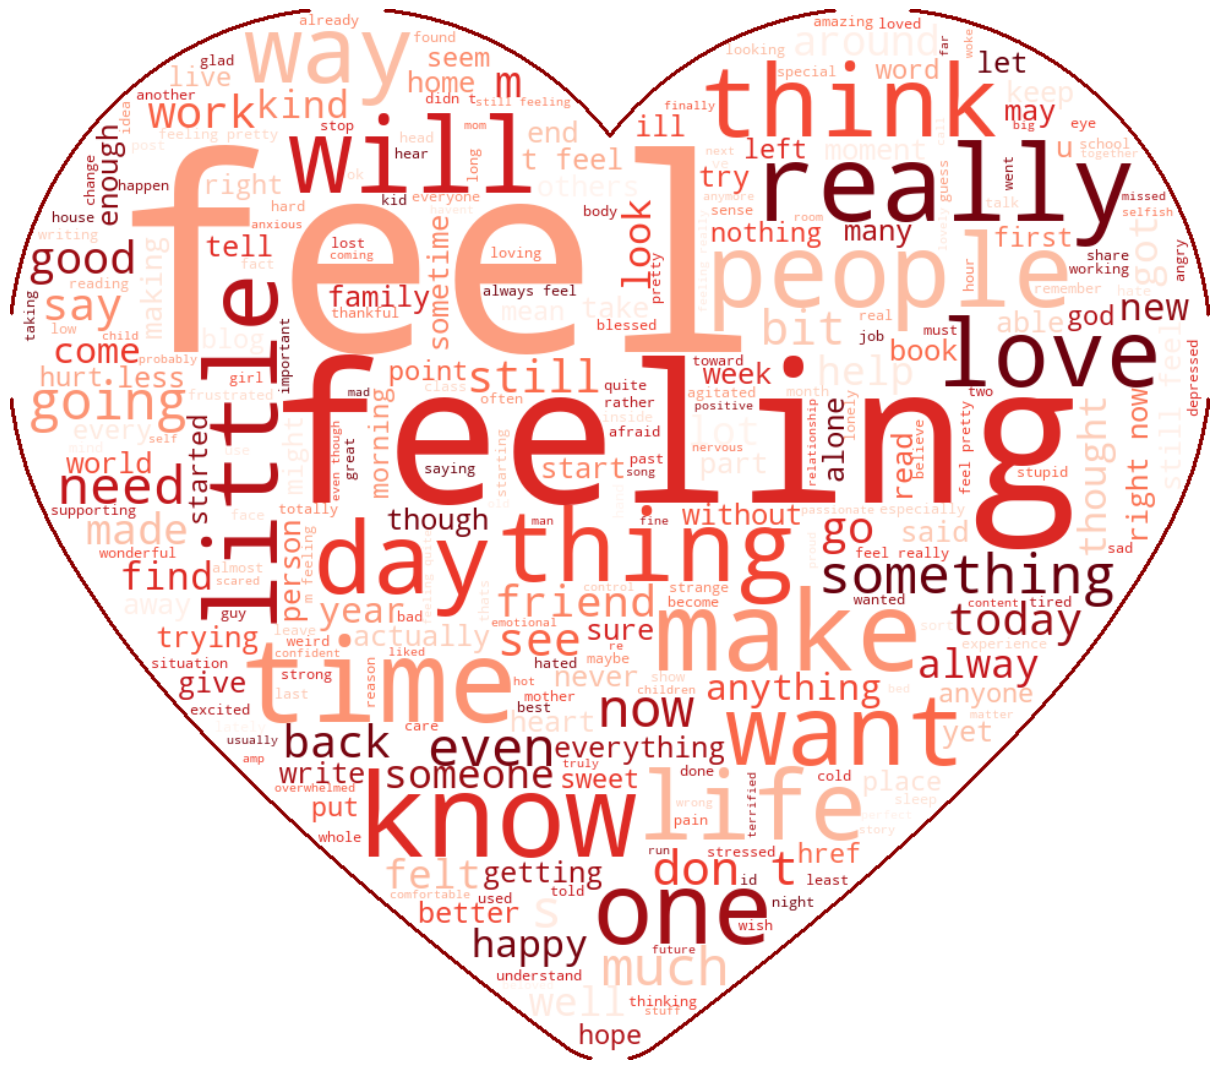

In [8]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the solid heart mask (your heart.png)
mask_array = np.array(Image.open("../utils/heart.png").convert("L"))

# Extra stopwords
stopwords = set(STOPWORDS)
stopwords.update(["im", "ive", "dont", "didnt", "cant", "couldnt", "rt"])

# Combine text
all_text = " ".join(dataset["text"].astype(str).tolist())

# Create WordCloud
wordcloud = WordCloud(
    width=2000,
    height=2000,
    background_color="white",
    mask=mask_array,
    colormap="Reds",
    contour_width=3,
    contour_color="darkred",
    stopwords=stopwords,
    max_words=300,
    prefer_horizontal=0.9
).generate(all_text)

# Display
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [9]:
import sys
sys.path.append("..")
import joblib
from utils.cleaning import heavy_clean

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Load Logistic Regression model
log_reg_model = joblib.load("../models/log_reg_model.pkl")
tfidf_vectorizer = joblib.load("../utils/tfidf_vectorizer.pkl")

# Example prediction
text = "I am very happy today!"
text_clean = heavy_clean(text)
vector = tfidf_vectorizer.transform([text_clean])

pred = log_reg_model.predict(vector)
emotion = id2label[int(pred[0])]

print("Logistic Regression Prediction →", emotion)


Logistic Regression Prediction → joy


In [10]:
import sys
sys.path.append("..")
import joblib
from utils.cleaning import heavy_clean

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Load Naive Bayes model
nb_model = joblib.load("../models/naive_bayes_model.pkl")
count_vectorizer = joblib.load("../utils/count_vectorizer.pkl")

text = "I feel terrible today..."
text_clean = heavy_clean(text)
vector = count_vectorizer.transform([text_clean])

pred = nb_model.predict(vector)
emotion = id2label[int(pred[0])]

print("Naive Bayes Prediction →", emotion)


Naive Bayes Prediction → sadness


In [11]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import json
import importlib
import utils.vocab_tools
importlib.reload(utils.vocab_tools)

from utils.cleaning import light_clean
from utils.vocab_tools import numericalize_tokens, pad_sequence_to_len

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

class BiLSTMEmotion(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True,
            num_layers=2
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        final_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(final_hidden)

# Load vocabulary
with open("../models/vocab.json", "r") as f:
    vocab = json.load(f)

# Load trained model
bilstm_model = BiLSTMEmotion(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_classes=6
)

bilstm_model.load_state_dict(
    torch.load("../models/bilstm_model.pth", map_location="cpu")
)
bilstm_model.eval()

def predict_bilstm(text):
    clean = light_clean(text)
    tokens = clean.split()
    nums = numericalize_tokens(tokens, vocab)
    nums = pad_sequence_to_len(nums, max_len=67)
    x = torch.tensor([nums])

    with torch.no_grad():
        logits = bilstm_model(x).softmax(dim=1)[0]
        pred = logits.argmax().item()

    return id2label[pred]

text = "I am feeling sad today"
print("BiLSTM Prediction →", predict_bilstm(text))


BiLSTM Prediction → sadness


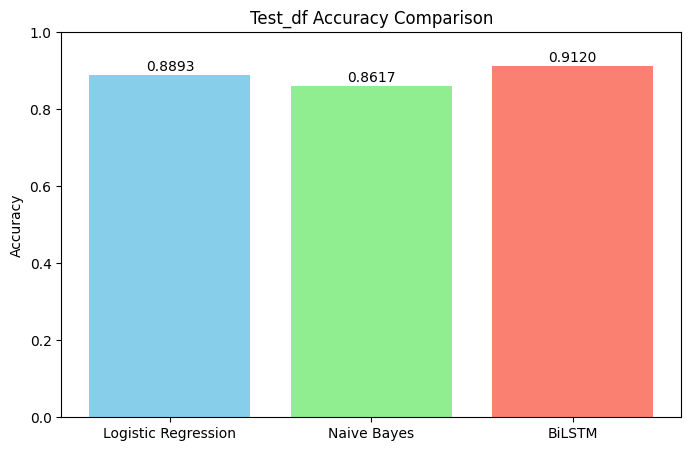

In [13]:
import matplotlib.pyplot as plt

acc_logreg = 0.8893
acc_nb = 0.8617
acc_bilstm = 0.9120

models = ["Logistic Regression", "Naive Bayes", "BiLSTM"]
accuracies = [acc_logreg, acc_nb, acc_bilstm]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=["skyblue", "lightgreen", "salmon"])
plt.ylim(0, 1)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.title("Test_df Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [22]:
def compare_models(text):
    results = {}

    # Logistic Regression
    clean_lr = heavy_clean(text)
    vec_lr = tfidf_vectorizer.transform([clean_lr])
    probs_lr = log_reg_model.predict_proba(vec_lr)[0]
    pred_lr = int(log_reg_model.predict(vec_lr)[0])
    emotion_lr = emotion_map[pred_lr]
    sentiment_lr = emotion_to_sentiment[emotion_lr]

    results["Logistic Regression"] = {
        "emotion": emotion_lr,
        "sentiment": sentiment_lr,
        "probs": probs_lr
    }

    # Naive Bayes
    clean_nb = heavy_clean(text)
    vec_nb = count_vectorizer.transform([clean_nb])
    probs_nb = nb_model.predict_proba(vec_nb)[0]
    pred_nb = int(nb_model.predict(vec_nb)[0])
    emotion_nb = emotion_map[pred_nb]
    sentiment_nb = emotion_to_sentiment[emotion_nb]

    results["Naive Bayes"] = {
        "emotion": emotion_nb,
        "sentiment": sentiment_nb,
        "probs": probs_nb
    }

    # BiLSTM 
    clean_dl = light_clean(text)
    tokens = clean_dl.split()
    nums = numericalize_tokens(tokens, vocab)
    nums = pad_sequence_to_len(nums, max_len=67)

    x = torch.tensor([nums])

    with torch.no_grad():
        logits = bilstm_model(x).softmax(dim=1).numpy()[0]

    pred_dl = int(logits.argmax())
    emotion_dl = emotion_map[pred_dl]
    sentiment_dl = emotion_to_sentiment[emotion_dl]

    results["BiLSTM"] = {
        "emotion": emotion_dl,
        "sentiment": sentiment_dl,
        "probs": logits
    }

    # Table display
    df = pd.DataFrame({
        "Emotion": list(emotion_map.values()),
        "Logistic Regression": probs_lr,
        "Naive Bayes": probs_nb,
        "BiLSTM": logits,
        "Pred LR": ["⬅️" if i == pred_lr else "" for i in range(6)],
        "Pred NB": ["⬅️" if i == pred_nb else "" for i in range(6)],
        "Pred DL": ["⬅️" if i == pred_dl else "" for i in range(6)]
    })

    display(df.style.format({
        "Logistic Regression": "{:.3f}",
        "Naive Bayes": "{:.3f}",
        "BiLSTM": "{:.3f}"
    }).background_gradient(cmap="Blues"))

    # Plot comparison curve
    plt.figure(figsize=(9,5))
    plt.plot(df["Emotion"], probs_lr, label="Logistic Regression", marker='o')
    plt.plot(df["Emotion"], probs_nb, label="Naive Bayes", marker='o')
    plt.plot(df["Emotion"], logits, label="BiLSTM", marker='o')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f"Model Confidence for: \"{text}\"")
    plt.show()

    return results


,Emotion,Logistic Regression,Naive Bayes,BiLSTM,Pred LR,Pred NB,Pred DL
0,sadness,0.424,0.612,0.333,⬅️,⬅️,⬅️
1,joy,0.145,0.041,0.151,,,
2,love,0.047,0.037,0.003,,,
3,anger,0.228,0.215,0.306,,,
4,fear,0.144,0.085,0.206,,,
5,surprise,0.012,0.010,0.001,,,


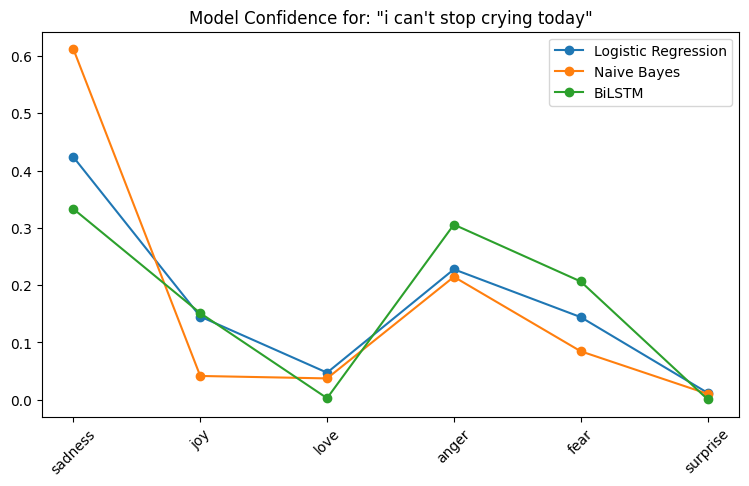

,Emotion,Logistic Regression,Naive Bayes,BiLSTM,Pred LR,Pred NB,Pred DL
0,sadness,0.270,0.325,0.289,,⬅️,⬅️
1,joy,0.330,0.306,0.180,⬅️,,
2,love,0.112,0.302,0.002,,,
3,anger,0.161,0.034,0.256,,,
4,fear,0.095,0.021,0.272,,,
5,surprise,0.033,0.012,0.001,,,


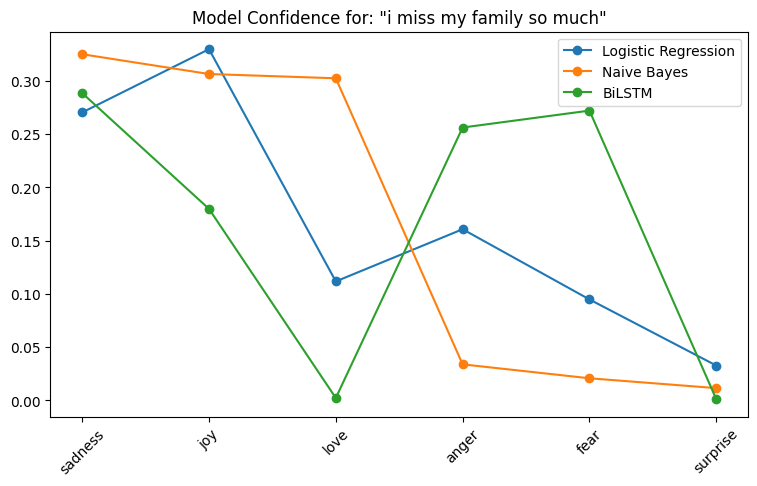

,Emotion,Logistic Regression,Naive Bayes,BiLSTM,Pred LR,Pred NB,Pred DL
0,sadness,0.997,0.882,0.273,⬅️,⬅️,
1,joy,0.001,0.044,0.164,,,
2,love,0.000,0.010,0.003,,,
3,anger,0.001,0.029,0.334,,,⬅️
4,fear,0.001,0.027,0.225,,,
5,surprise,0.000,0.008,0.000,,,


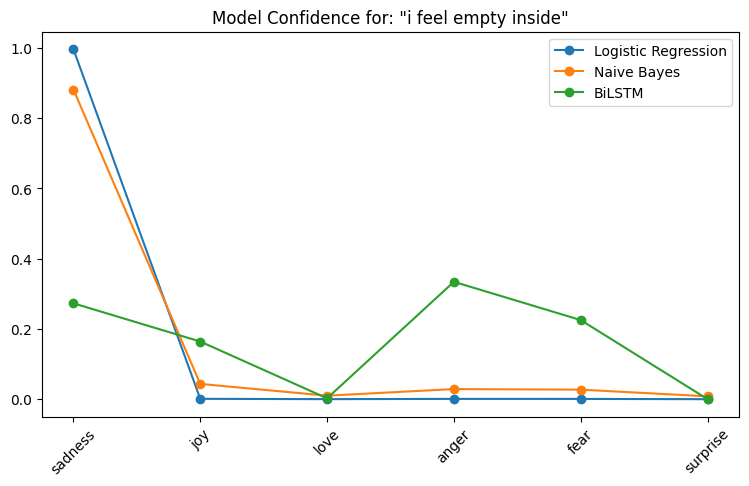

,Emotion,Logistic Regression,Naive Bayes,BiLSTM,Pred LR,Pred NB,Pred DL
0,sadness,0.192,0.388,0.208,,⬅️,
1,joy,0.427,0.276,0.152,⬅️,,
2,love,0.070,0.069,0.005,,,
3,anger,0.135,0.148,0.463,,,⬅️
4,fear,0.159,0.102,0.172,,,
5,surprise,0.017,0.017,0.001,,,


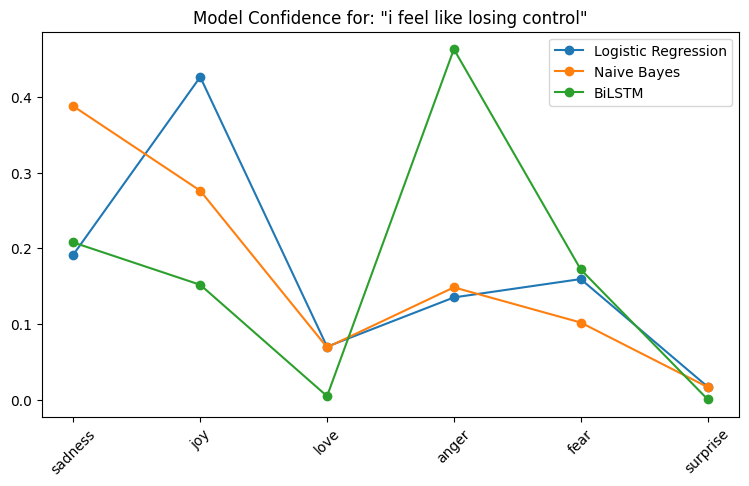

,Emotion,Logistic Regression,Naive Bayes,BiLSTM,Pred LR,Pred NB,Pred DL
0,sadness,0.912,0.585,0.303,⬅️,⬅️,⬅️
1,joy,0.039,0.109,0.197,,,
2,love,0.005,0.019,0.003,,,
3,anger,0.027,0.192,0.295,,,
4,fear,0.015,0.077,0.201,,,
5,surprise,0.002,0.018,0.001,,,


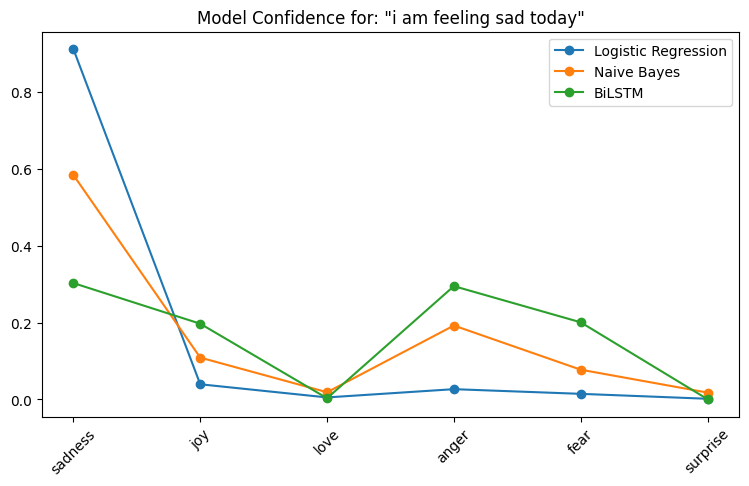

{'Logistic Regression': {'emotion': 'sadness',
  'sentiment': 'negative',
  'probs': array([0.91223265, 0.03947699, 0.00524147, 0.02673735, 0.01457348,
         0.00173807])},
 'Naive Bayes': {'emotion': 'sadness',
  'sentiment': 'negative',
  'probs': array([0.58450101, 0.10895914, 0.01874259, 0.19248929, 0.07746643,
         0.01784153])},
 'BiLSTM': {'emotion': 'sadness',
  'sentiment': 'negative',
  'probs': array([0.30302233, 0.19720925, 0.00314489, 0.2951205 , 0.20086871,
         0.00063426], dtype=float32)}}

In [33]:
compare_models("i can't stop crying today")
compare_models("i miss my family so much")
compare_models("i feel empty inside")
compare_models("i feel like losing control")
compare_models("i am feeling sad today")

In [38]:
import numpy as np
from utils.cleaning import heavy_clean

emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

sentiment_groups = {
    "positive": ["joy", "love"],
    "negative": ["anger", "fear"],
    "neutral": ["sadness", "surprise"]
}

def predict_emotion_and_sentiment(text):
    cleaned = heavy_clean(text)

    X = tfidf_vectorizer.transform([cleaned])

    # IMPORTANT: using log_reg, not log_reg_model
    probs = log_reg_model.predict_proba(X)[0]

    best_idx = int(np.argmax(probs))
    emotion_pred = emotion_labels[best_idx]

    sentiment_scores = {}
    for sent_name, emos in sentiment_groups.items():
        sentiment_scores[sent_name] = float(
            sum(probs[emotion_labels.index(e)] for e in emos)
        )

    total = sum(sentiment_scores.values())
    if total > 0:
        for k in sentiment_scores:
            sentiment_scores[k] /= total

    sentiment_pred = max(sentiment_scores, key=sentiment_scores.get)

    return emotion_pred, sentiment_pred, sentiment_scores

In [39]:
def show_sentiment(text):
    emotion, sentiment, scores = predict_emotion_and_sentiment(text)

    print("📝 Text:")
    print(" ", text)
    print("\n🎭 Predicted emotion:", emotion.upper())
    print("💬 Overall sentiment:", sentiment.upper())
    print("\n📊 Sentiment scores:")
    print(f"  positive: {scores['positive']:.2f}")
    print(f"  neutral : {scores['neutral']:.2f}")
    print(f"  negative: {scores['negative']:.2f}")

In [40]:
show_sentiment("I am super happy today!")

📝 Text:
  I am super happy today!

🎭 Predicted emotion: JOY
💬 Overall sentiment: POSITIVE

📊 Sentiment scores:
  positive: 1.00
  neutral : 0.00
  negative: 0.00
